In [1]:
import copy
import pickle
import pdb

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import optimize
from astropy.timeseries import LombScargle

import radvel
from radvel.plot import orbit_plots, mcmc_plots

import rvsearch
from rvsearch import search, utils

from analysis_scripts import sval_correlations

%matplotlib inline

# Notebook for handling data post-processing, such as S-value decorrelation, and modeling of yearly systematics.

## Model HD 3765 activity with square-exponential kernel. Set up the file here, run on cadence.

In [2]:
post = radvel.posterior.load('../3765/post_final.pkl')
data = pd.read_csv('../rvdata/vst3765.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../3765/post_final.pkl'

In [4]:
t = np.array(data.jd)
vel = np.array(data.mnvel)
errvel = np.array(data.errvel)
tel = np.array(data.tel)

telgrps = data.groupby('tel').groups
instnames = telgrps.keys()

In [5]:
post.params

Parameters([('per1',
             Parameter object: value = 1235.8553164376942, vary = True, mcmc scale = None),
            ('tc1',
             Parameter object: value = 2455618.025629988, vary = True, mcmc scale = None),
            ('secosw1',
             Parameter object: value = -0.012123674495171316, vary = True, mcmc scale = 0.005),
            ('sesinw1',
             Parameter object: value = -0.6324900170543468, vary = True, mcmc scale = 0.005),
            ('k1',
             Parameter object: value = 4.013436136166362, vary = True, mcmc scale = None),
            ('jit_j',
             Parameter object: value = 3.027068490583884, vary = True, mcmc scale = None),
            ('jit_k',
             Parameter object: value = 4.799254850767471, vary = True, mcmc scale = None),
            ('gamma_j',
             Parameter object: value = -0.6631529318729545, vary = False, mcmc scale = None),
            ('gamma_k',
             Parameter object: value = -0.47255188547620375,

In [6]:
nplanets = 1
params = radvel.Parameters(nplanets, basis='per tc secosw sesinw k')

params['per1'] = radvel.Parameter(value=1235.855, vary=True)
params['tc1'] = radvel.Parameter(value=2455618.0256, vary=True)
params['secosw1'] = radvel.Parameter(value=-0.01212367,vary=True)
params['sesinw1'] = radvel.Parameter(value=-0.63249002,vary=True)
params['k1'] = radvel.Parameter(value=4.0134, vary=True)
params['dvdt'] = radvel.Parameter(value=0.,vary=False)
params['curv'] = radvel.Parameter(value=0.,vary=False)

#Model activity with square-exponential term.
amp       = 2.98
explength = 1500 

params['gp_amp'] = radvel.Parameter(value=amp, vary=True)
params['gp_length'] = radvel.Parameter(value=explength, vary=True)

In [7]:
hnames = [
    'gp_amp', # eta_1; GP variability amplitude
    'gp_length' # eta_2; GP non-periodic characteristic length
]

model = radvel.model.RVModel(params)

# Make HIRES post-upgrade likelihood.
indices = telgrps['j']
like_j = radvel.likelihood.GPLikelihood(model, t[indices], vel[indices],
                                            errvel[indices], hnames, 
                                            suffix='_j',
                                            kernel_name="SqExp"
                                            )
like_j.params['gamma_j'] = radvel.Parameter(value=-0.2894, vary=False, linear=True)
like_j.params['jit_j'] = radvel.Parameter(value=3.338, vary=True)

# Make HIRES pre-upgrade likelihood.
indices = telgrps['k']
like_k = radvel.likelihood.GPLikelihood(model, t[indices], vel[indices],
                                          errvel[indices], hnames, 
                                          suffix='_k',
                                          kernel_name="SqExp"
                                          )
like_k.params['gamma_k'] = radvel.Parameter(value=-1.7889, vary=False, linear=True)
like_k.params['jit_k'] = radvel.Parameter(value=3.670, vary=True)

likes = [like_j, like_k]

In [8]:
gplike = radvel.likelihood.CompositeLikelihood(likes)
gppost = radvel.posterior.Posterior(gplike)
gppost.priors += [radvel.prior.Jeffreys('gp_amp', 0.01, 50.)]
gppost.priors += [radvel.prior.HardBounds('gp_length', 0, 8000)]
#gppost.priors += [radvel.prior.Gaussian('gp_length', explength, 1000.)]

In [9]:
res = optimize.minimize(
      gppost.neglogprob_array, gppost.get_vary_params(), method='Powell',
      options=dict(maxiter=500, maxfev=100000, xatol=1e-8)
      )
print(gppost)

parameter                     value      vary
per1                        1214.75       True
tc1                     2.45562e+06       True
secosw1                 -0.00502474       True
sesinw1                   -0.545819       True
k1                          3.83836       True
dvdt                              0      False
curv                              0      False
gp_amp                      1.77397       True
gp_length                   1096.63       True
gamma_j                     -0.2894      False
jit_j                       2.68183       True
gamma_k                     -1.7889      False
jit_k                        3.9112       True

Priors
------
Jeffrey's prior on gp_amp, min=0.01, max=50.0
Bounded prior on gp_length, min=0, max=8000



In [46]:
nwalkers = 20
nrun = 100
chains = radvel.mcmc(gppost, nwalkers=nwalkers, nrun=nrun, burnGR=1.03,
                     maxGR=1.0075, minTz=2000, minAfactor=15,
                     maxArchange=0.07, burnAfactor=15,
                     minsteps=0.5*nwalkers*nrun, minpercent=20, thin=5,
                     save=False, ensembles=12)

12000/24000 (50.0%) steps complete; Running 41.57 steps/s; Mean acceptance rate = 47.1%; Min Auto Factor =  27; Max Auto Relative-Change = 0.423; Min Tz = 6031.1; Max G-R = 1.011
Discarding burn-in now that the chains are marginally well-mixed

24000/24000 (100.0%) steps complete; Running 47.11 steps/s; Mean acceptance rate = 35.1%; Min Auto Factor =  18; Max Auto Relative-Change = 0.596; Min Tz = 1816.0; Max G-R = 1.038

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


## Download chains from cadence.

In [18]:
cadence_chains = pd.read_csv('../3765_gp_chains.csv.tar.bz2')

In [20]:
clip_chains = cadence_chains.query('k1 < 7.5 and gp_amp < 8 and jit_k > 0')
quants = clip_chains.quantile([0.159, 0.5, 0.841])
gppost.uparams   = {}
gppost.medparams = {}
gppost.maxparams = {}

for par in gppost.params.keys():
    if gppost.params[par].vary:
        med = quants[par][0.5]
        high = quants[par][0.841] - med
        low = med - quants[par][0.159]
        err = np.mean([high,low])
        err = radvel.utils.round_sig(err)
        med, err, errhigh = radvel.utils.sigfig(med, err)
        max, err, errhigh = radvel.utils.sigfig(
                            gppost.params[par].value, err)

        gppost.uparams[par] = err
        gppost.medparams[par] = med
        gppost.maxparams[par] = max

synthchains = gppost.params.basis.to_synth(clip_chains)
synthquants = synthchains.quantile([0.159, 0.5, 0.841])

for n in np.arange(1, gppost.params.num_planets+1):
    e_key = 'e{}'.format(n)
    w_key = 'w{}'.format(n)
    # Add period if it's a synthetic parameter.
    per_key = 'per{}'.format(n)

    med_e  = synthquants[e_key][0.5]
    high_e = synthquants[e_key][0.841] - med_e
    low_e  = med_e - synthquants[e_key][0.159]
    err_e  = np.mean([high_e,low_e])
    err_e  = radvel.utils.round_sig(err_e)
    med_e, err_e, errhigh_e = radvel.utils.sigfig(med_e, err_e)
    max_e, err_e, errhigh_e = radvel.utils.sigfig(
                              gppost.params[e_key].value, err_e)

    med_w  = synthquants[w_key][0.5]
    high_w = synthquants[w_key][0.841] - med_w
    low_w  = med_w - synthquants[w_key][0.159]
    err_w  = np.mean([high_w,low_w])
    err_w  = radvel.utils.round_sig(err_w)
    med_w, err_w, errhigh_w = radvel.utils.sigfig(med_w, err_w)
    max_w, err_w, errhigh_w = radvel.utils.sigfig(
                              gppost.params[w_key].value, err_w)

    gppost.uparams[e_key]   = err_e
    gppost.uparams[w_key]   = err_w
    gppost.medparams[e_key] = med_e
    gppost.medparams[w_key] = med_w
    gppost.maxparams[e_key] = max_e
    gppost.maxparams[w_key] = max_w

In [21]:
gppost.params

Parameters([('per1',
             Parameter object: value = 1214.748463107038, vary = True, mcmc scale = None),
            ('tc1',
             Parameter object: value = 2455616.3278694903, vary = True, mcmc scale = None),
            ('secosw1',
             Parameter object: value = -0.005024737643588559, vary = True, mcmc scale = None),
            ('sesinw1',
             Parameter object: value = -0.545818666954859, vary = True, mcmc scale = None),
            ('k1',
             Parameter object: value = 3.83836058793202, vary = True, mcmc scale = None),
            ('dvdt',
             Parameter object: value = 0.0, vary = False, mcmc scale = None),
            ('curv',
             Parameter object: value = 0.0, vary = False, mcmc scale = None),
            ('gp_amp',
             Parameter object: value = 1.7739684735903196, vary = True, mcmc scale = None),
            ('gp_length',
             Parameter object: value = 1096.626309841606, vary = True, mcmc scale = None),
  

KeyError: 'e1'

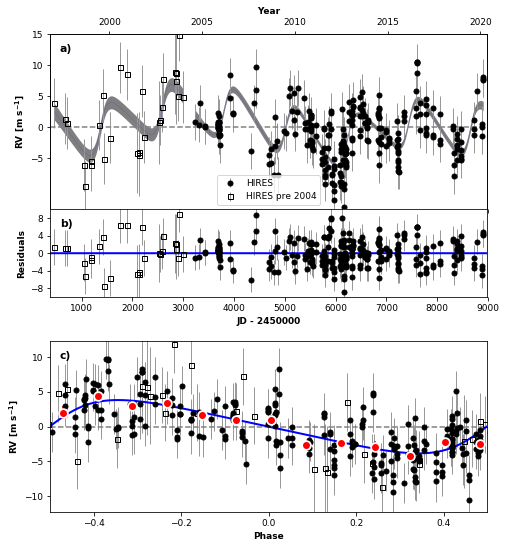

In [12]:
GPPlot = orbit_plots.GPMultipanelPlot(
         gppost, uparams=gppost.uparams,
         saveplot='3765_gp.pdf',
         subtract_gp_mean_model=False,
         plot_likelihoods_separately=False,
         subtract_orbit_model=False
         )
GPPlot.plot_multipanel()
GPPlot.saveplot()

Corner plot saved to ../3765_gp_dcorner.pdf


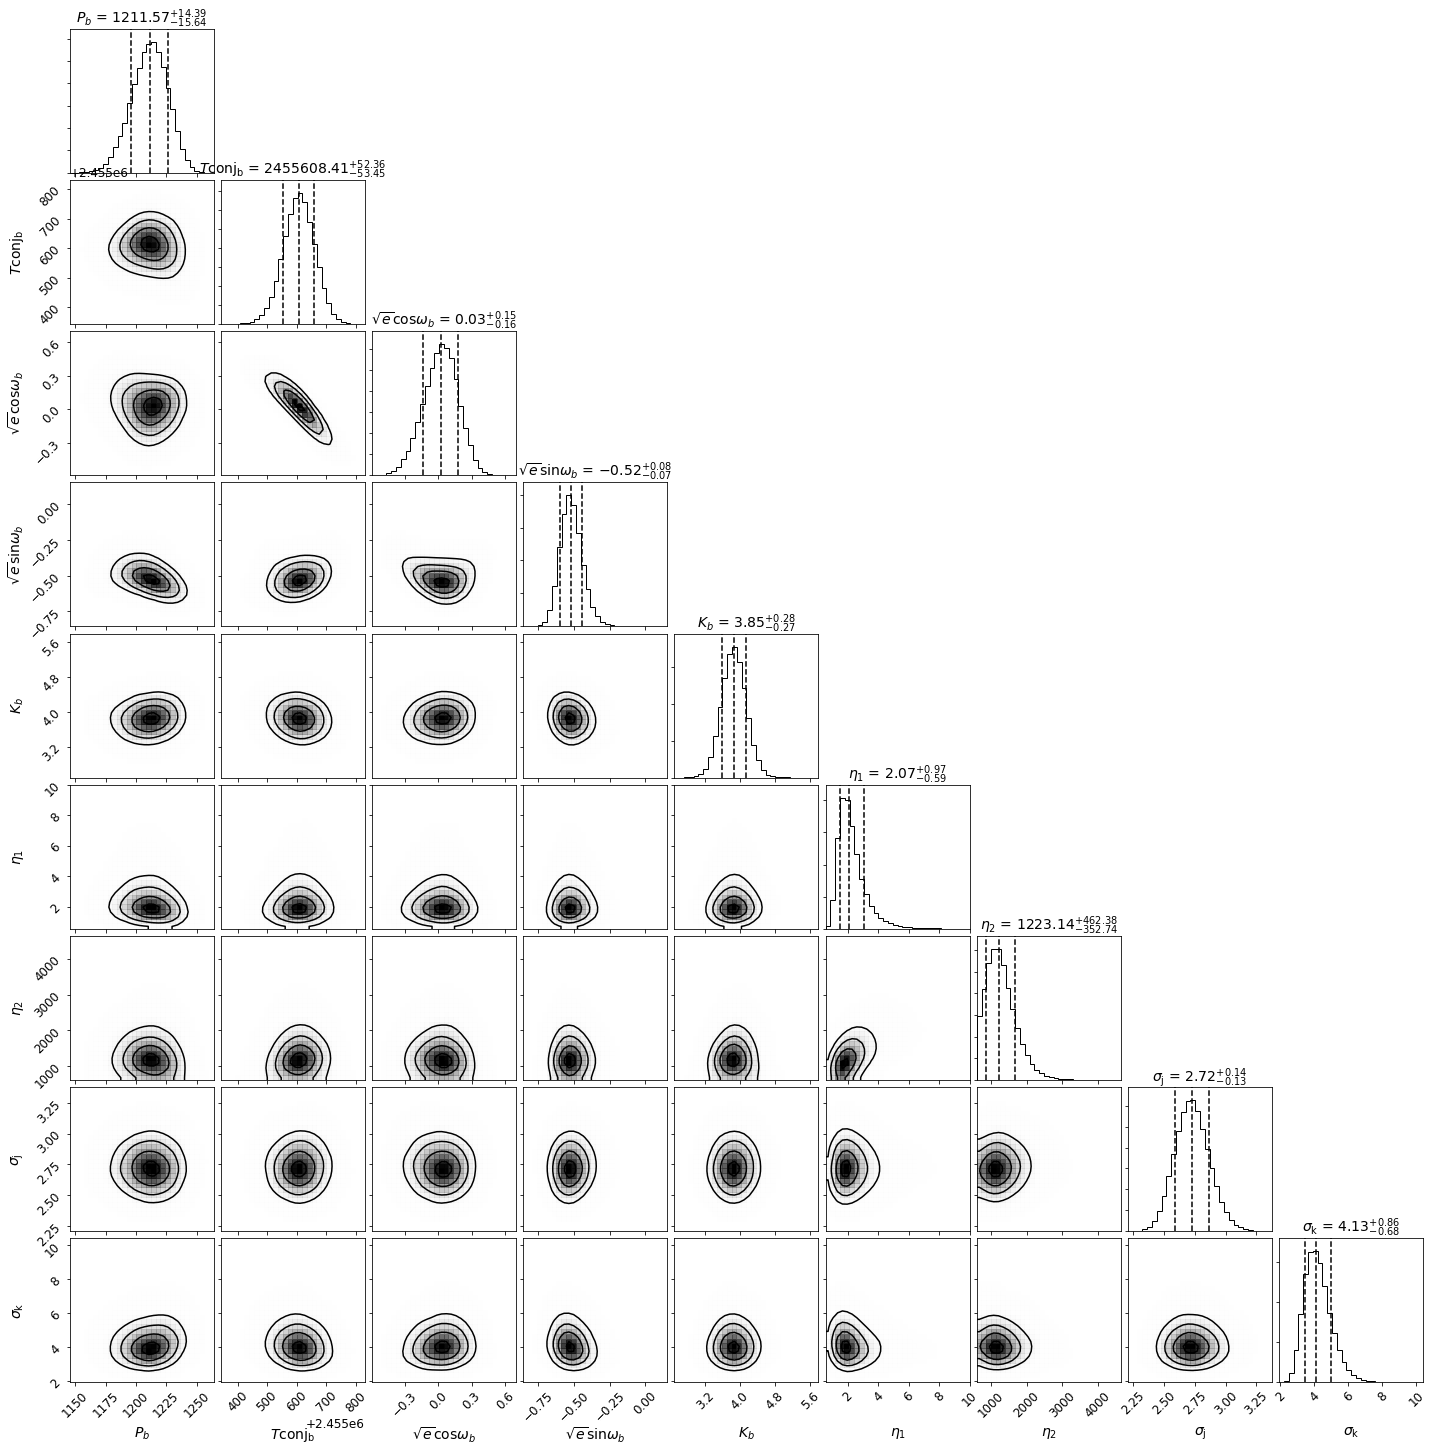

In [22]:
Corner = mcmc_plots.CornerPlot(gppost, cadence_chains,
                               saveplot='../3765_gp_dcorner.pdf')
figure = Corner.plot()

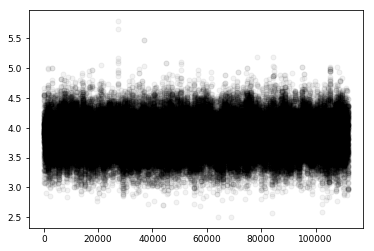

In [88]:
k = cadence_chains['k1'] #.query('k1 < 7.5 and gp_amp < 8')

fig, ax = plt.subplots()
ax.scatter(np.arange(len(k)), k, alpha=0.05, color='black')

In [65]:
cadence_chains.columns

Index(['Unnamed: 0', 'per1', 'tc1', 'secosw1', 'sesinw1', 'k1', 'gp_amp',
       'gp_length', 'jit_j', 'jit_k', 'lnprobability'],
      dtype='object')

## Predict RV increase for 26161.

In [4]:
post = radvel.posterior.load('../funky_systems/26161/post_final.pkl')
data = pd.read_csv('../rvdata/vst26161.csv').query('cts > 3000')

pchains = pd.read_csv('../funky_systems/26161/26161_pchains.csv')
jchains = pd.read_csv('Joker_results/26161_chains_combined.csv')
jchains['tp'] = np.array(data.jd[0]) + jchains['P'] * jchains['M0']/(2*np.pi)

data_k = data.query('tel == "k"')
data_j = data.query('tel == "j"')
data_a = data.query('tel == "apf"')

data_j['mnvel'] = data_j['mnvel'] - post.params['gamma_j'].value
data_k['mnvel'] = data_k['mnvel'] - post.params['gamma_k'].value
data_a['mnvel'] = data_a['mnvel'] - post.params['gamma_apf'].value

data_j['errvel'] = np.sqrt(data_j['errvel']**2 + post.params['jit_j'].value**2)
data_k['errvel'] = np.sqrt(data_k['errvel']**2 + post.params['jit_k'].value**2)

v0 = np.array(data_k.mnvel)[0]
orbel = [post.params['per1'].value,
         post.params['tp1'].value,
         post.params['e1'].value,
         post.params['w1'].value,
         post.params['k1'].value]
mod = radvel.kepler.rv_drive(data['jd'].values, orbel)

In [ ]:
Mstar = np.random.normal(1.113, 0.076, len(jchains)).clip(0.001, 100)

In [11]:
masses = radvel.utils.Msini(jchains.K, jchains.P, Mstar, jchains.e, Msini_units='jupiter')
axes = radvel.utils.semi_major_axis(jchains.P, Mstar)

In [15]:
print(np.percentile(masses, 15.9), np.percentile(masses, 50), np.percentile(masses, 84.1))
print(np.percentile(axes, 15.9), np.percentile(axes, 50), np.percentile(axes, 84.1))
print(np.percentile(jchains.e, 15.9), np.percentile(jchains.e, 50), np.percentile(jchains.e, 84.1))
print(np.percentile(jchains.P, 15.9), np.percentile(jchains.P, 50), np.percentile(jchains.P, 84.1))
print(np.percentile(jchains.K, 15.9), np.percentile(jchains.K, 50), np.percentile(jchains.K, 84.1))

9.804049098449763 13.547044609400334 21.96079157490204
15.603416400883667 20.343040173910268 28.66915927179423
0.7682381023647381 0.81919825534023 0.8813644548988017
21296.042518481765 31580.28377148076 53190.38211625331
100.69149423798473 140.49535457605992 238.3182069110161


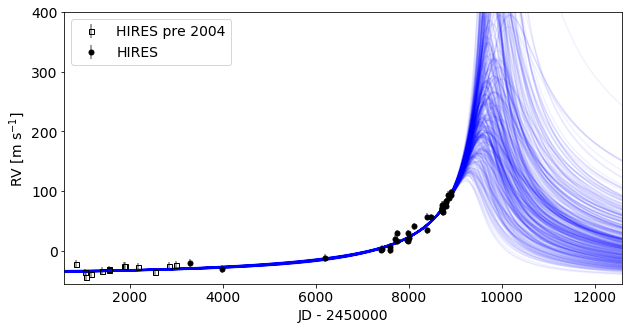

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
matplotlib.rcParams.update({'font.size': 18})
ax.set_xlabel('JD - 2450000')
ax.set_ylabel(r'RV [m s$^{-1}$]')

markers, caps, bars = ax.errorbar(data_k.jd - 2450000, data_k.mnvel, data_k.errvel,
            fmt='o', marker='s', markerfacecolor='none', 
            markeredgecolor='black', color='black', alpha=1, label='HIRES pre 2004')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
markers, caps, bars = ax.errorbar(data_j.jd - 2450000, data_j.mnvel, data_j.errvel,
            fmt='o', color='black', alpha=1, label='HIRES')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
'''
markers, caps, bars = ax.errorbar(data_a.jd - 2450000, data_a.mnvel, data_a.errvel, # - np.median(data_a.mnvel)
            fmt='o', marker='d', color='green', alpha=0.5, label='APF')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
'''

times = np.linspace(600, 20000, num=1000) #10*(np.amax(data.jd) - np.amin(data.jd))
for i in np.arange(len(jchains)):
    orbel = [np.array(jchains.P)[i],
             np.array(jchains.tp)[i],
             np.array(jchains.e)[i],
             np.array(jchains.omega)[i], #wmod
             np.array(jchains.K)[i]]
    rvmod = radvel.kepler.rv_drive(2450000 + times, orbel) + np.array(jchains.v0)[i]
    ax.plot(times-200, rvmod + 50, color='blue', alpha=0.05) # - rvmod[0] + np.median(data_k.mnvel), 
    ax.set_xlim([600, 12600])
    #ax.set_xlim([600, 20000])
    ax.set_ylim([-55, 400])

matplotlib.rcParams.update({'font.size': 14})
ax.legend()
fig.savefig('Joker_results/26161_blue_orbits.png', dpi=1000)

## SUGGEST THAT WE WILL SEE SOMETHING INTERESTING IN THE NEXT X YEARS

## Do the same for HD 213472.

In [6]:
post = radvel.posterior.load('../funky_systems/213472/post_final.pkl')
data = pd.read_csv('../rvdata/vst213472.csv').query('cts > 3000')

jchains = pd.read_csv('Joker_results/213472_chains_0109.csv').query('wmod < 1.2')
jchains['tp'] = np.array(data.jd[0]) + jchains['P'] * jchains['M0']/(2*np.pi)

data_k = data.query('tel == "k"')
data_j = data.query('tel == "j"')

data_j['mnvel'] = data_j['mnvel'] - post.params['gamma_j'].value
data_k['mnvel'] = data_k['mnvel'] - post.params['gamma_k'].value

#data_j['errvel'] = np.sqrt(data_j['errvel']**2 + post.params['jit_j'].value**2)
#data_k['errvel'] = np.sqrt(data_k['errvel']**2 + post.params['jit_k'].value**2)

v0 = np.array(data_k.mnvel)[0]

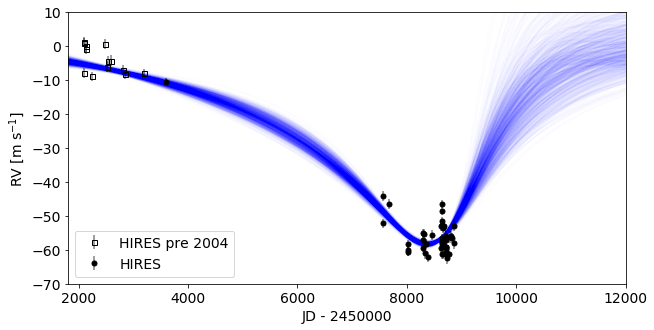

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
matplotlib.rcParams.update({'font.size': 18})
ax.set_xlabel('JD - 2450000')
ax.set_ylabel(r'RV [m s$^{-1}$]')

markers, caps, bars = ax.errorbar(data_k.jd - 2450000, data_k.mnvel, data_k.errvel,
            fmt='o', marker='s', markerfacecolor='none', 
            markeredgecolor='black', color='black', alpha=1, label='HIRES pre 2004')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
markers, caps, bars = ax.errorbar(data_j.jd - 2450000, data_j.mnvel, data_j.errvel,
            fmt='o', color='black', alpha=1, label='HIRES')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

matplotlib.rcParams.update({'font.size': 14})
times = np.linspace(1800, 12000, num=1000)
for i in np.arange(len(jchains)):
    orbel = [np.array(jchains.P)[i],
             np.array(jchains.tp)[i],
             np.array(jchains.e)[i],
             np.array(jchains.wmod)[i] + np.pi,
             np.array(jchains.K)[i]]
    rvmod = radvel.kepler.rv_drive(2450000 + times, orbel) + np.array(jchains.v0)[i]
    rvmod0 = radvel.kepler.rv_drive(np.array([np.array(data_k.jd)[0]]), orbel) + np.array(jchains.v0)[i]
    ax.plot(times, rvmod - 55.2, color='blue', alpha=0.01) # HOW TO COMPUTE 55?
    ax.set_xlim([1800, 12000])
    ax.set_ylim([-70, 10])
ax.legend()
fig.savefig('Joker_results/213472_blue_orbits.png', dpi=1000)